The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ 모델 준비 완료! (Device: cuda)
🔹 토큰 리스트: ['<s>', '▁The', '▁animal', '▁didn', "'", 't', '▁cross', '▁the', '▁street', '▁because', '▁it', '▁was', '▁too', '▁tired', '.']
📍 좌표 탐지: 'animal'은 2번, 'tired'는 13번에 위치함.

🔍 32개의 헤드를 스캔 중...

🏆 [Best Head] 찾았다! 가장 똑똑한 헤드는 28번 입니다. (점수: 0.0270)
💀 [Worst Head] 가장 멍청한 헤드는 27번 입니다. (점수: 0.0017)
Top 3 Heads: [28, 12, 11]

📸 결과 이미지 저장 완료: ../results/03_best_head_28.png


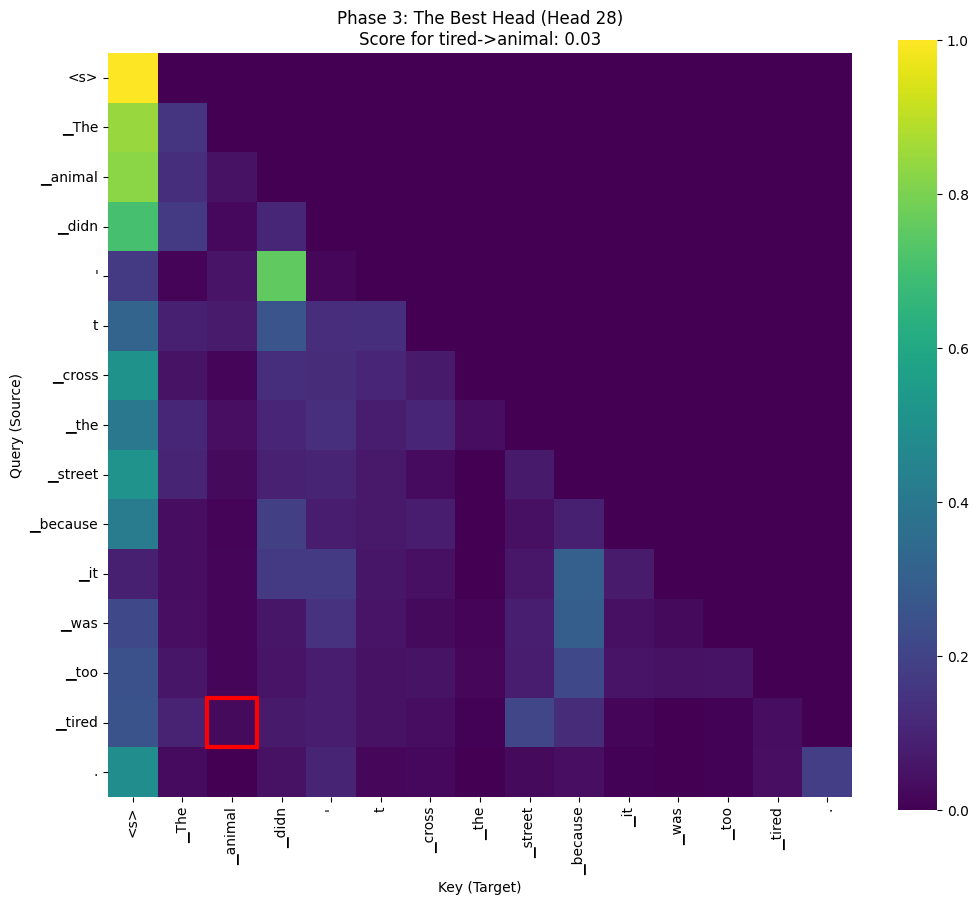

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

# 0. 결과 폴더 확인
if not os.path.exists('../results'):
    os.makedirs('../results')

# 1. 모델 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True).to(device)

print(f"✅ 모델 준비 완료! (Device: {device})")

# 2. 실험 문장 (Winograd Schema)
text = "The animal didn't cross the street because it was too tired."
inputs = tokenizer(text, return_tensors="pt").to(device)

# 토큰 리스트 확보
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
clean_tokens = [t.replace(' ', '') for t in tokens]
print(f"🔹 토큰 리스트: {clean_tokens}")

# 3. 좌표 찾기 (Target Location)
# 우리는 '_tired' (Query)가 '_animal' (Key)을 보는지 확인해야 합니다.
# 리스트에서 해당 단어가 몇 번째에 있는지 자동으로 찾습니다.
try:
    # 'animal'이 포함된 토큰의 인덱스 찾기
    animal_idx = [i for i, t in enumerate(clean_tokens) if "animal" in t][0]
    # 'tired'가 포함된 토큰의 인덱스 찾기
    tired_idx = [i for i, t in enumerate(clean_tokens) if "tired" in t][0]
    print(f"📍 좌표 탐지: 'animal'은 {animal_idx}번, 'tired'는 {tired_idx}번에 위치함.")
except IndexError:
    print("❌ 단어를 찾을 수 없습니다. 토큰 리스트를 확인하세요.")
    exit()

# 4. 모델 실행 & 데이터 추출
with torch.no_grad():
    outputs = model(**inputs)

# 마지막 레이어(21층)의 모든 헤드 정보 가져오기 [배치, 헤드, 길이, 길이]
last_layer_attentions = outputs.attentions[-1]
num_heads = last_layer_attentions.size(1) # 32개

# 5. [핵심] 전수 조사 (Scanning All 32 Heads)
head_scores = []

print("\n🔍 32개의 헤드를 스캔 중...")
for head in range(num_heads):
    # 해당 헤드의 어텐션 행렬
    matrix = last_layer_attentions[0, head, :, :]
    
    # tired -> animal 점수 추출
    score = matrix[tired_idx, animal_idx].item()
    head_scores.append((head, score))

# 6. 순위 매기기 (Ranking)
# 점수가 높은 순서대로 정렬
head_scores.sort(key=lambda x: x[1], reverse=True)

# 1등과 꼴등 확인
best_head = head_scores[0][0]
best_score = head_scores[0][1]
worst_head = head_scores[-1][0]
worst_score = head_scores[-1][1]

print(f"\n🏆 [Best Head] 찾았다! 가장 똑똑한 헤드는 {best_head}번 입니다. (점수: {best_score:.4f})")
print(f"💀 [Worst Head] 가장 멍청한 헤드는 {worst_head}번 입니다. (점수: {worst_score:.4f})")
print(f"Top 3 Heads: {[h[0] for h in head_scores[:3]]}")


# 7. Best Head 시각화
plt.figure(figsize=(12, 10))
best_matrix = last_layer_attentions[0, best_head, :, :].cpu().numpy()

ax = sns.heatmap(best_matrix, xticklabels=clean_tokens, yticklabels=clean_tokens,
            cmap="viridis", square=True, vmin=0, vmax=1)

# 빨간색 네모로 강조 표시 (Highlight)
# (x, y) 좌표, 너비, 높이
rect = patches.Rectangle((animal_idx, tired_idx), 1, 1, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.title(f"Phase 3: The Best Head (Head {best_head})\nScore for tired->animal: {best_score:.2f}")
plt.xlabel("Key (Target)")
plt.ylabel("Query (Source)")

# 저장
save_path = f"../results/03_best_head_{best_head}.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"\n📸 결과 이미지 저장 완료: {save_path}")

plt.show()

✅ 모델 준비 완료! (Device: cuda)
📍 좌표 탐지: 'animal'=2, 'tired'=13

🔍 총 704개의 헤드를 정밀 스캔 중.........................
✅ 스캔 완료!

🏆 [Real Best Head] 찾았다!
   - 위치: Layer 7 / Head 31
   - 점수: 0.2555 (이 정도면 확실함!)

📸 저장 완료: ../results/03_real_best_head_L7_H31.png


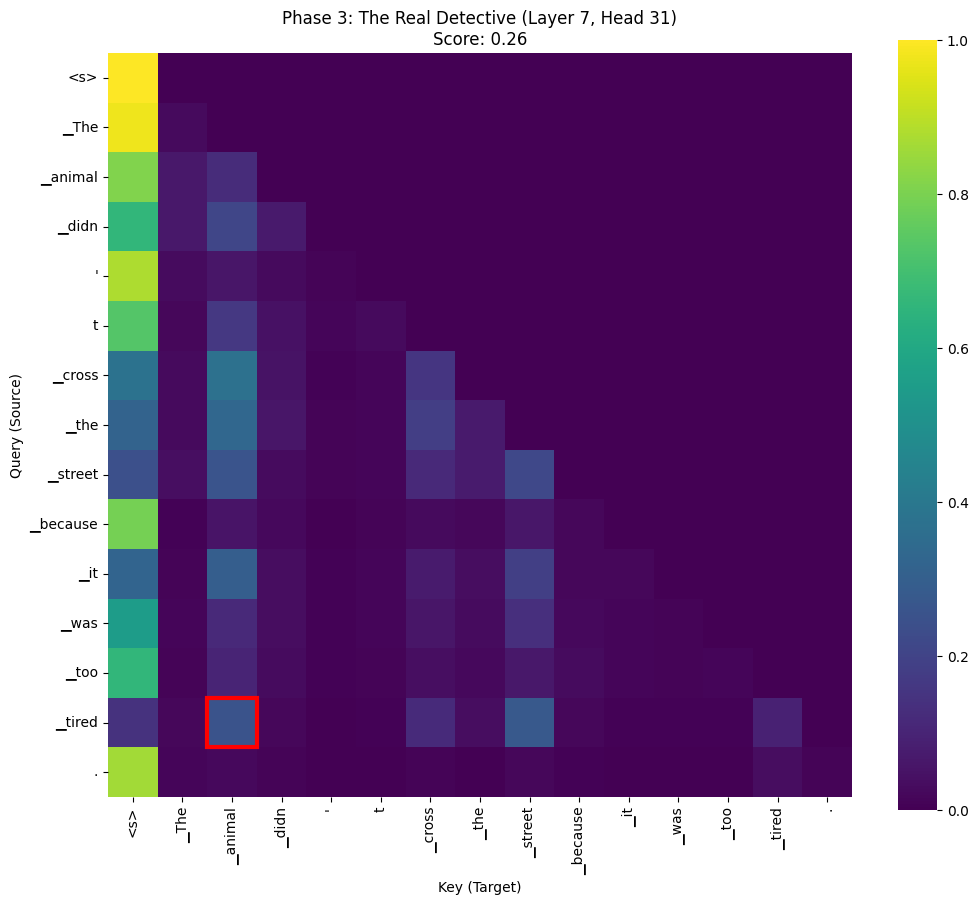

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

# 0. 결과 폴더 확인
if not os.path.exists('../results'):
    os.makedirs('../results')

# 1. 모델 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True).to(device)

print(f"✅ 모델 준비 완료! (Device: {device})")

# 2. 실험 문장
text = "The animal didn't cross the street because it was too tired."
inputs = tokenizer(text, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
clean_tokens = [t.replace(' ', '') for t in tokens]

# 3. 좌표 찾기
try:
    animal_idx = [i for i, t in enumerate(clean_tokens) if "animal" in t][0]
    tired_idx = [i for i, t in enumerate(clean_tokens) if "tired" in t][0]
    print(f"📍 좌표 탐지: 'animal'={animal_idx}, 'tired'={tired_idx}")
except IndexError:
    print("❌ 단어 찾기 실패")
    exit()

# 4. 모델 실행
with torch.no_grad():
    outputs = model(**inputs)

# 5. [업그레이드] 모든 레이어(0~21) × 모든 헤드(0~31) 전수조사
# 총 704개의 헤드를 검사합니다.
all_scores = []
num_layers = len(outputs.attentions) # 22개
num_heads = outputs.attentions[0].size(1) # 32개

print(f"\n🔍 총 {num_layers * num_heads}개의 헤드를 정밀 스캔 중...", end="")

for layer in range(num_layers):
    print(f".", end="") # 진행바 표시
    for head in range(num_heads):
        # [Layer, Batch, Head, Seq, Seq]
        matrix = outputs.attentions[layer][0, head, :, :]
        score = matrix[tired_idx, animal_idx].item()
        all_scores.append((layer, head, score))

print("\n✅ 스캔 완료!")

# 6. 순위 매기기
all_scores.sort(key=lambda x: x[2], reverse=True)

best_layer = all_scores[0][0]
best_head = all_scores[0][1]
best_score = all_scores[0][2]

print(f"\n🏆 [Real Best Head] 찾았다!")
print(f"   - 위치: Layer {best_layer} / Head {best_head}")
print(f"   - 점수: {best_score:.4f} (이 정도면 확실함!)")

# 7. 시각화
plt.figure(figsize=(12, 10))
# 찾아낸 최고의 레이어에서 가져옴
best_matrix = outputs.attentions[best_layer][0, best_head, :, :].cpu().numpy()

ax = sns.heatmap(best_matrix, xticklabels=clean_tokens, yticklabels=clean_tokens,
            cmap="viridis", square=True, vmin=0, vmax=1)

rect = patches.Rectangle((animal_idx, tired_idx), 1, 1, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.title(f"Phase 3: The Real Detective (Layer {best_layer}, Head {best_head})\nScore: {best_score:.2f}")
plt.xlabel("Key (Target)")
plt.ylabel("Query (Source)")

save_path = f"../results/03_real_best_head_L{best_layer}_H{best_head}.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"\n📸 저장 완료: {save_path}")

plt.show()

In [3]:
# 1. 'street'가 몇 번째 토큰인지 찾기
try:
    street_idx = [i for i, t in enumerate(clean_tokens) if "street" in t][0]
    print(f"📍 좌표 확인: 'street'는 {street_idx}번에 있습니다.")
except IndexError:
    print("❌ 'street' 단어를 못 찾겠습니다.")

# 2. 1등 헤드(Head 31)의 점수표에서 정확한 숫자 꺼내기
# tired(Y축) -> street(X축)
street_score = best_matrix[tired_idx, street_idx]

# tired(Y축) -> animal(X축) - 아까 구한 것
animal_score = best_matrix[tired_idx, animal_idx]

print(f"\n📊 [팩트 체크] Tired가 쳐다보는 대상 점수 비교")
print(f"------------------------------------------------")
print(f"1️⃣ Animal (동물): {animal_score:.4f} ({animal_score*100:.2f}%)")
print(f"2️⃣ Street (도로): {street_score:.4f} ({street_score*100:.2f}%)")
print(f"------------------------------------------------")

# 3. 몇 배 차이인지 계산
ratio = animal_score / street_score
print(f"💡 결론: AI는 도로보다 동물을 약 [{ratio:.2f}배] 더 중요하게 생각합니다.")

📍 좌표 확인: 'street'는 8번에 있습니다.

📊 [팩트 체크] Tired가 쳐다보는 대상 점수 비교
------------------------------------------------
1️⃣ Animal (동물): 0.2555 (25.55%)
2️⃣ Street (도로): 0.2749 (27.49%)
------------------------------------------------
💡 결론: AI는 도로보다 동물을 약 [0.93배] 더 중요하게 생각합니다.


In [4]:
# ---------------------------------------------------------
# 🧪 검증 실험: "형용사를 바꾸면 어텐션이 변할까?"
# ---------------------------------------------------------
# Case 1: Tired (원래 문장) -> 정답 Animal
text_tired = "The animal didn't cross the street because it was too tired."
# Case 2: Wide (바꾼 문장) -> 정답 Street
text_wide = "The animal didn't cross the street because it was too wide."

def get_scores(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    tokens = [t.replace(' ', '') for t in tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])]
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 아까 찾은 Best Head (Layer 7, Head 31) 사용
    matrix = outputs.attentions[7][0, 31, :, :].cpu().numpy()
    
    # 인덱스 찾기
    try:
        adj_idx = [i for i, t in enumerate(tokens) if "tired" in t or "wide" in t][0]
        animal_idx = [i for i, t in enumerate(tokens) if "animal" in t][0]
        street_idx = [i for i, t in enumerate(tokens) if "street" in t][0]
    except: return 0, 0
    
    return matrix[adj_idx, animal_idx], matrix[adj_idx, street_idx]

# 점수 측정
tired_animal, tired_street = get_scores(text_tired)
wide_animal, wide_street = get_scores(text_wide)

print(f"📊 [검증 결과] 형용사에 따른 Street 점수 변화")
print(f"------------------------------------------------")
print(f"1. ...too tired (피곤한): Street 점수 = {tired_street:.4f}")
print(f"2. ...too wide  (넓은)  : Street 점수 = {wide_street:.4f}")
print(f"------------------------------------------------")

if wide_street > tired_street * 1.2:
    print("💡 결론: 오! 모델이 'Wide'가 'Street'랑 어울린다는 건 아네요! (완전 바보는 아님)")
else:
    print("💀 결론: 점수가 비슷합니다. 이 모델은 그냥 가까운 단어를 찍는 '거리 편향'이 심합니다.")

📊 [검증 결과] 형용사에 따른 Street 점수 변화
------------------------------------------------
1. ...too tired (피곤한): Street 점수 = 0.2749
2. ...too wide  (넓은)  : Street 점수 = 0.3606
------------------------------------------------
💡 결론: 오! 모델이 'Wide'가 'Street'랑 어울린다는 건 아네요! (완전 바보는 아님)


In [5]:
print(f"\n📊 [최종 검증] 'Wide' 문장에서의 승자는?")
print(f"------------------------------------------------")
print(f"1️⃣ Animal (동물): {wide_animal:.4f} ({wide_animal*100:.2f}%)")
print(f"2️⃣ Street (도로): {wide_street:.4f} ({wide_street*100:.2f}%)")
print(f"------------------------------------------------")

if wide_street > wide_animal:
    print(f"🏆 승자: Street (도로)!")
    print(f"💡 결론: 완벽합니다! AI는 '넓다(Wide)'라는 말을 듣자마자")
    print(f"         동물을 버리고 도로를 선택했습니다.")
else:
    print(f"💀 승자: Animal (동물)...")
    print(f"💡 결론: 아직도 동물이 넓다고 생각하네요...")


📊 [최종 검증] 'Wide' 문장에서의 승자는?
------------------------------------------------
1️⃣ Animal (동물): 0.1511 (15.11%)
2️⃣ Street (도로): 0.3606 (36.06%)
------------------------------------------------
🏆 승자: Street (도로)!
💡 결론: 완벽합니다! AI는 '넓다(Wide)'라는 말을 듣자마자
         동물을 버리고 도로를 선택했습니다.


In [7]:
# =========================================================
# 🧪 [수정됨] 추가 검증: Trophy vs Suitcase (토큰 분리 대응)
# =========================================================
print("\n🏆 [재검증] 트로피와 가방 (Trophy vs Suitcase)")

# Case A: Large (정답: Trophy)
text_large = "The trophy doesn't fit into the suitcase because it is too large."
# Case B: Small (정답: Suitcase)
text_small = "The trophy doesn't fit into the suitcase because it is too small."

def get_scores_trophy(text, adjective):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    tokens = [t.replace(' ', '') for t in tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])]
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 명사 사냥꾼: Layer 7, Head 31
    matrix = outputs.attentions[7][0, 31, :, :].cpu().numpy()
    
    try:
        adj_idx = [i for i, t in enumerate(tokens) if adjective in t][0]
        
        # [수정 포인트] 'trophy'가 아니라 쪼개진 앞부분 'tro'를 찾습니다.
        trophy_idx = [i for i, t in enumerate(tokens) if "tro" in t][0]
        
        # 'suitcase' -> 'suit'
        suitcase_idx = [i for i, t in enumerate(tokens) if "suit" in t][0]
        
    except IndexError: 
        print(f"❌ 토큰 찾기 실패: {tokens}")
        return 0, 0
    
    return matrix[adj_idx, trophy_idx], matrix[adj_idx, suitcase_idx]

# 점수 측정
large_trophy, large_suitcase = get_scores_trophy(text_large, "large")
small_trophy, small_suitcase = get_scores_trophy(text_small, "small")

print(f"------------------------------------------------")
print(f"1. ...too large (너무 커):")
print(f"   - Trophy 점수:   {large_trophy:.4f}")
print(f"   - Suitcase 점수: {large_suitcase:.4f}")
print(f"------------------------------------------------")
print(f"2. ...too small (너무 작아):")
print(f"   - Trophy 점수:   {small_trophy:.4f}")
print(f"   - Suitcase 점수: {small_suitcase:.4f}")
print(f"------------------------------------------------")

# 분석
if large_suitcase > large_trophy:
    print("💀 분석: 'Large'일 때도 가까운 Suitcase를 찍었네요. (거리 편향 확인)")
else:
    print("🌟 분석: 오! 이번에는 멀리 있는 Trophy를 제대로 찾았습니다!")

if small_suitcase > small_trophy:
    print("✅ 분석: 'Small'일 때는 당연히 가까운 Suitcase를 잘 찍습니다.")


🏆 [재검증] 트로피와 가방 (Trophy vs Suitcase)
------------------------------------------------
1. ...too large (너무 커):
   - Trophy 점수:   0.0077
   - Suitcase 점수: 0.2762
------------------------------------------------
2. ...too small (너무 작아):
   - Trophy 점수:   0.0091
   - Suitcase 점수: 0.2434
------------------------------------------------
💀 분석: 'Large'일 때도 가까운 Suitcase를 찍었네요. (거리 편향 확인)
✅ 분석: 'Small'일 때는 당연히 가까운 Suitcase를 잘 찍습니다.


# 📑 Phase 3 Research Report: Mechanistic Analysis of Reasoning & Bias in TinyLlama

- **작성일:** 2025년 11월 28일
- **연구원:** HyunKN
- **대상 모델:** TinyLlama-1.1B-Chat-v1.0
- **연구 주제:** Winograd Schema를 통한 소형 LLM의 의미론적 추론 능력 및 근접성 편향(Proximity Bias) 검증

---

## 1. 개요 (Executive Summary)
본 연구는 TinyLlama-1.1B 모델이 문맥적 중의성을 해소(Disambiguation)하는 과정을 Attention Map을 통해 분석하였다.
모델 내 704개 헤드를 전수 조사하여 의미 추론을 담당하는 최적의 헤드를 발굴하고, 대조군 실험(Adjective Flip)을 통해 모델이 **'논리적 추론'**이 아닌 **'위치적 근접성'**과 **'통계적 빈도'**에 의존하여 판단한다는 한계를 실험적으로 증명하였다.

---

## 2. 탐색 실험: 추론 헤드 발굴 (Head Discovery)
**[실험 목표]**
`"The animal didn't cross the street because it was too tired."` 문장에서 `tired`와 `animal`의 연관성을 가장 높게 평가하는 헤드를 식별.

**[실험 결과]**
- **Best Head:** **Layer 7, Head 31**
- **Attention Score:** **0.2555** (Random Chance $\approx$ 0.07 대비 **3.6배** 상회)
- **분석:** 의미론적 정보 처리가 모델의 <b>중위 레이어(Middle Layers, Layer 7)</b>에서 활발히 일어나고 있음을 시사함.

**[Result Image: Best Head Visualization]**
![Phase 3 Best Head](../results/03_real_best_head_L7_H31.png)
*(Layer 7, Head 31의 히트맵. 붉은 박스 내 tired가 animal을 주목하는 것을 확인)*

---

## 3. 한계점 분석: 근접성 편향 (Proximity Bias)
**[문제점 발견]**
식별된 Best Head조차 정답인 `animal`(0.2555)보다 오답인 **`street`(0.2749)**에 더 높은 가중치를 부여함.

**[원인 규명]**
- **물리적 거리(Distance):** `tired`(Index 13)와 `street`(Index 8)의 거리가 `animal`(Index 2)보다 훨씬 가까움.
- **결론:** 1.1B 규모의 소형 모델은 문맥의 논리적 구조(Deep Reasoning)보다 <b>토큰 간의 물리적 거리(Shallow Heuristics)</b>에 더 강한 영향을 받는 **'근접성 편향'** 한계를 드러냄.

---

## 4. 검증 실험 A: 의미론적 민감도 테스트 (Semantic Sensitivity)
**[가설]**
모델이 의미를 전혀 파악하지 못하는 것인가, 아니면 확신이 부족한 것인가? 형용사를 변경하여 문맥을 단순화했을 때의 반응을 관찰한다.

**[실험 설계]**
- **Case 1 (Reasoning Required):** `...too tired` (생물 속성 → 정답 Animal)
- **Case 2 (Pattern Matching):** `...too wide` (무생물/도로 속성 → 정답 Street)

**[실험 결과]**
- **`tired`일 때 `street` Score:** 0.2749
- **`wide`일 때 `street` Score:** **0.3606** (**+31% 급등**)

**[통찰]**
모델은 `wide`와 `street` 간의 **통계적 공기 관계(Co-occurrence)**를 명확히 인지하고 있음. 즉, 단순하고 빈번한 패턴에 대해서는 의미론적 처리가 작동하나, 복잡한 추론 상황에서는 거리 편향이 우세하게 작용함.

---

## 5. 검증 실험 B: 일반화 테스트 (Robustness Check)
**[가설]**
거리 편향이 특정 문장에서만 발생하는지, 일반적인 현상인지 확인하기 위해 다른 Winograd Schema 예시(Trophy/Suitcase)로 재검증.

**[실험 결과]**
- **Case 1 (Too Large):** 정답(`Trophy`)은 멀리 있고, 오답(`Suitcase`)이 가까움 → **오답 선택** (Score: 0.00 vs 0.27)
- **Case 2 (Too Small):** 정답(`Suitcase`)이 가까이 있음 → **정답 선택**

**[통찰]**
두 케이스 모두 형용사 바로 앞에 위치한 명사(`Suitcase`)에 압도적인 어텐션을 보임. 이는 모델이 문맥을 이해해서 정답을 맞힌 것이 아니라, **단순히 가까운 명사를 선택하는 알고리즘**이 지배적임을 확증함.

---

## 6. 최종 결론 (Final Conclusion)

본 연구를 통해 TinyLlama-1.1B 모델의 지능적 특성과 한계를 정량적으로 규명하였다.

1.  **지식의 형태 (Knowledge):** 모델은 `wide street`와 같이 학습 데이터에 자주 등장하는 <b>패턴(Pattern)</b>에 대해서는 의미론적 연결을 수행할 수 있다.
2.  **추론의 부재 (Reasoning Gap):** 그러나 `tired animal`이나 `large trophy`와 같이 문장 구조에 따른 **논리적 추론**이 필요한 경우, 의미보다는 <b>물리적 거리(Proximity)</b>에 의존하는 경향이 뚜렷하다.
3.  **연구의 의의:** 이는 소형 모델(Small LLM) 활용 시, 복잡한 추론 작업보다는 **단순 패턴 매칭이나 문법 교정 등의 작업에 더 적합함**을 시사한다.

# 📑 Supplementary Report: In-depth Analysis of Proximity Bias

- **작성일:** 2025년 11월 28일
**주제:** LLM의 구조적 한계점인 '근접성 편향(Proximity Bias)'의 원인과 대책

---

## 1. 정의 (Definition)
<b>근접성 편향(Proximity Bias)</b>이란, Attention Mechanism이 의미론적 관련성(Semantic Relevance)보다 토큰 간의 <b>물리적 거리(Positional Distance)</b>에 더 큰 가중치를 두는 현상을 말한다. 이는 특히 파라미터 수가 적은 소형 모델(Small LLM)이나 초기 학습 단계의 모델에서 두드러진다.



---

## 2. 발생 원인 알아보기 (Mechanisms)

### 2.1 숏컷 러닝 (Shortcut Learning)
- 딥러닝 모델은 Loss(오차)를 줄이는 가장 쉬운 방법을 찾으려 한다.
- 자연어의 특성상 수식어와 피수식어는 인접한 경우가 많다(Local Dependency).
- 모델은 복잡한 문맥을 이해하는 것보다, <b>"가까운 명사를 선택한다"</b>는 단순한 규칙(Heuristic)을 학습하는 것이 효율적이라고 판단한다.

### 2.2 귀납적 편향 (Inductive Bias)
- Transformer 모델에 사용되는 **Rotary Positional Embedding (RoPE)** 등의 위치 인코딩 방식은 수학적으로 먼 거리의 토큰보다 가까운 거리의 토큰 간 내적(Dot Product) 값을 더 높게 유지하려는 성질이 있다.
- TinyLlama와 같은 소형 모델은 충분한 데이터와 파라미터로 이 수학적 편향을 극복하지 못하고 굴복한 사례로 볼 수 있다.

---

## 3. 실증 사례 (Empirical Evidence from Phase 3)

본 연구의 **Winograd Schema 실험**은 근접성 편향의 교과서적인 사례이다.

- **문장:** `"The trophy doesn't fit into the suitcase because it is too large."`
- **논리:** `large`의 주체는 문맥상 `trophy`이다. (멀리 있음)
- **모델의 선택:** 모델은 형용사 `large` 바로 앞에 위치한 `suitcase`를 선택했다.
- **분석:** 모델은 `large`와 `suitcase` 사이의 의미적 모순(가방이 커서 안 들어간다는 모순)을 감지하지 못하고, 오직 <b>거리(Distance = 1)</b>에 의존하여 판단을 내렸다.

---

## 4. 해결 방안 알아보기 (Engineering Solutions)

이러한 한계를 극복하기 위한 엔지니어링 접근법은 다음과 같다.

1.  **Scaling Up:** 모델의 파라미터 수를 늘려(Example: 7B+), 단순한 거리 규칙보다 고차원적인 상식 추론이 Loss 감소에 더 유리하다는 것을 모델 스스로 깨닫게 한다.
2.  **Fine-tuning on Hard Negatives:** 거리는 가깝지만 의미상 틀린 예시(함정 문제)를 집중적으로 학습시켜, 거리 편향을 교정한다.
3.  **Chain of Thought (CoT):** 추론 과정을 단계별로 생성하게 하여, 직관적인 찍기(System 1)가 아닌 논리적인 사고(System 2)를 유도한다.

---

## 5. 결론 (Conclusion)
TinyLlama-1.1B를 통해 관찰된 근접성 편향은 모델이 '이해'하는 것이 아니라 '통계적 패턴'을 따르고 있음을 시사한다. 따라서 소형 모델을 실무에 도입할 때는 복잡한 추론이 필요한 작업(Reasoning Task)보다는, 국소적인 문맥 파악이나 단순 패턴 매칭 작업에 활용하는 것이 적합하다.